In [16]:
#hide
from utils import *
from fastai.vision.widgets import *

In [ ]:
images = []

# grizzly bear data
file = 'grizzly_bears.json'
with open(file) as f:
    data = json.load(f)

grizzly_image_links = []
for result in data["value"]:
    grizzly_image_links.append(result["contentUrl"])

images.append(grizzly_image_links)

# black bear data
file = 'black_bears.json'
with open(file) as f:
    data = json.load(f)

black_image_links = []
for result in data["value"]:
    black_image_links.append(result["contentUrl"])

images.append(black_image_links)

# teddy bear data
file = 'teddy_bears.json'
with open(file) as f:
    data = json.load(f)

teddy_image_links = []
for result in data["value"]:
    teddy_image_links.append(result["contentUrl"])

images.append(teddy_image_links)

example = images[0][7]

In [ ]:
dest = 'images/grizzly.jpg'
download_url(example, dest, overwrite=True)
help(download_url)

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [17]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    a = 0
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        for index, link in enumerate(images[a]):
            download_url(link, str(dest) + "/" + str(index) + ".jpg", overwrite=True)
        a += 1

In [ ]:
fns = get_image_files(path)
fns

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink);

In [18]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bears.dataloaders(path)

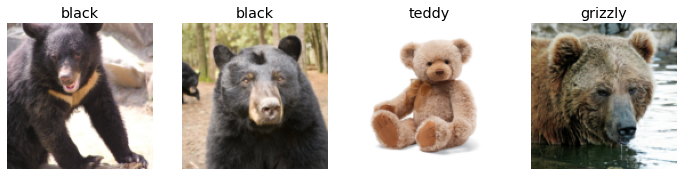

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

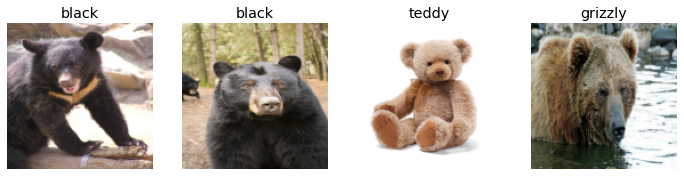

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

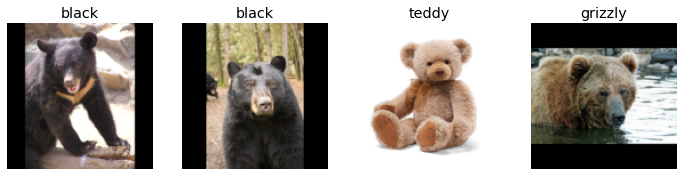

In [23]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

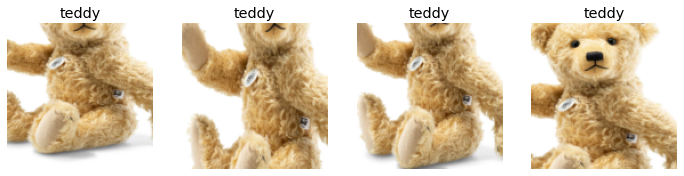

In [24]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

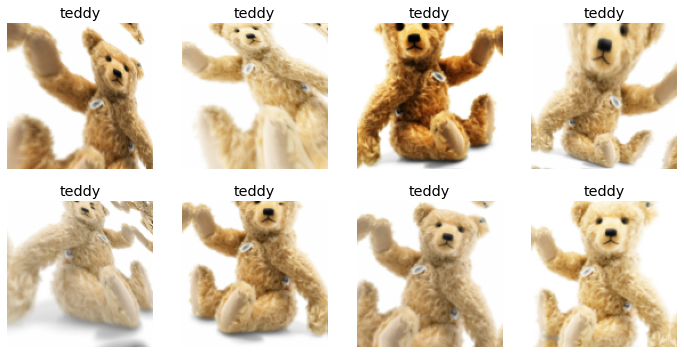

In [25]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [26]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.252041,3.059532,0.800000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.792477,1.862544,0.700000,00:05
1,1.527587,0.317202,0.150000,00:05
2,1.143305,0.084908,0.000000,00:05
3,0.903947,0.053400,0.000000,00:05


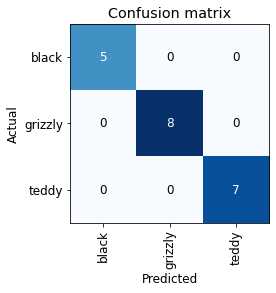

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

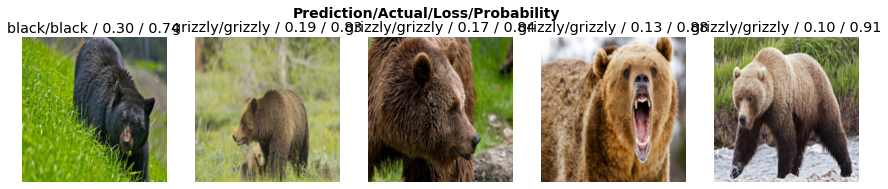

In [30]:
interp.plot_top_losses(5, nrows=1)

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [34]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([0.0270, 0.9471, 0.0259]))

In [39]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

In [40]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [41]:
#hide
# For the book, we can't actually click an upload button, so we fake it
# btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

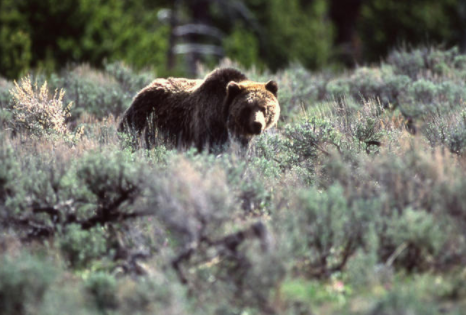

In [43]:
img = PILImage.create(btn_upload.data[-1])
img

In [44]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [45]:
pred,pred_idx,probs = learn_inf.predict(img)

In [46]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9896')

In [47]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [48]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [49]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [50]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [51]:
#hide
!jupyter serverextension enable voila —sys-prefix

Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
      voila 0.1.23 OK
